## Loading and Reading the dataset

In [2]:
from google.colab import files
import zipfile
import os
import pandas as pd

# Upload the file
uploaded = files.upload()

# Path to the uploaded zip file
zip_path = '/content/titanic (1).zip'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/titanic_data/')

# List all files in the extracted folder
extracted_files = os.listdir('/content/titanic_data/')
print("Extracted files:", extracted_files)

# Assuming the extracted CSV file is named 'train.csv' (change the name if needed)
csv_file_path = '/content/titanic_data/train.csv'  # Update the file name if needed

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Display the first few rows of the dataframe
df.head()


Saving titanic (1).zip to titanic (1).zip
Extracted files: ['test.csv', 'train.csv', 'gender_submission.csv']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Titanic Dataset - Classification Pipeline


#  5.2 Experimental Setup + feature engineering
In this section, we'll set up our experimental framework and implement advanced feature engineering techniques to improve model performance. Our goal is to achieve an accuracy greater than 84% on the Titanic survival prediction task.

# 5.3 Performance Measures We will use:

Accuracy: The proportion of correct predictions among the total number of predictions
Classification Report: Provides precision, recall, and F1-score for each class
Confusion Matrix: Visualizes true positives, false positives, true negatives, and false negatives

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import warnings
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from google.colab import files
import zipfile
import os

# Suppress warnings
warnings.filterwarnings("ignore")

# Upload the file
uploaded = files.upload()

# Path to the uploaded zip file
zip_path = '/content/titanic (1).zip'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/titanic_data/')

# List all files in the extracted folder
extracted_files = os.listdir('/content/titanic_data/')
print("Extracted files:", extracted_files)

# Assuming the extracted CSV file is named 'train.csv'
csv_file_path = '/content/titanic_data/train.csv'  # Update the file name if needed

# Load dataset
train_df = pd.read_csv(csv_file_path)

# Advanced Feature Engineering
def advanced_feature_engineering(df):
    df_processed = df.copy()

    # Family size & Alone
    df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1
    df_processed['IsAlone'] = (df_processed['FamilySize'] == 1).astype(int)

    # Extract and simplify titles
    df_processed['Title'] = df_processed['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    title_map = {
        "Mr": "Mr", "Miss": "Miss", "Mrs": "Mrs", "Master": "Master",
        "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
        "Dr": "Rare", "Rev": "Rare", "Col": "Rare", "Major": "Rare",
        "Countess": "Rare", "Lady": "Rare", "Jonkheer": "Rare",
        "Don": "Rare", "Dona": "Rare", "Capt": "Rare", "Sir": "Rare"
    }
    df_processed['Title'] = df_processed['Title'].map(lambda x: title_map.get(x, "Rare"))

    # Fill missing values
    df_processed['Age'] = df_processed.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
    df_processed['Fare'] = df_processed.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    df_processed['Embarked'] = df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0])

    # Bin Age and Fare
    df_processed['AgeBin'] = pd.cut(df_processed['Age'], bins=[0, 12, 20, 40, 60, 100], labels=[0, 1, 2, 3, 4])
    df_processed['FareBin'] = pd.qcut(df_processed['Fare'], 6, labels=False)

    # Encode categorical features
    le = LabelEncoder()
    df_processed['Sex'] = le.fit_transform(df_processed['Sex'])
    df_processed['Embarked'] = le.fit_transform(df_processed['Embarked'])

    # Interaction & composite features
    df_processed['Sex_Pclass'] = df_processed['Sex'] * df_processed['Pclass']
    df_processed['Age_Pclass'] = df_processed['Age'] * df_processed['Pclass']
    df_processed['Fare_Per_Person'] = df_processed['Fare'] / df_processed['FamilySize']
    df_processed['Age_Class_Fare'] = df_processed['Age'] * df_processed['Pclass'] * df_processed['Fare']
    df_processed['Fare_log'] = np.log1p(df_processed['Fare'])
    df_processed['Age_log'] = np.log1p(df_processed['Age'])
    df_processed['Family_Survival'] = df_processed['FamilySize'] * df_processed['Survived'].mean()

    # Cabin features
    df_processed['Has_Cabin'] = df_processed['Cabin'].notnull().astype(int)
    df_processed['Cabin_Letter'] = df_processed['Cabin'].str[0].fillna('U')

    # One-hot encode titles, pclass, cabin letters
    df_processed = pd.get_dummies(df_processed, columns=['Title', 'Pclass', 'Cabin_Letter'], drop_first=True)

    # Drop unused columns
    df_processed.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'], inplace=True)

    return df_processed

# Process data
df_processed = advanced_feature_engineering(train_df)

# Define features and target
X = df_processed.drop(columns=['Survived'])
y = df_processed['Survived']
feature_names = X.columns  # Save column names before scaling

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection
def select_features(X, y, feature_names):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    print("Feature ranking:")
    for i in range(min(20, len(feature_names))):
        print(f"{i+1}. {feature_names[indices[i]]} ({importances[indices[i]]:.5f})")

    selector = SelectFromModel(rf, threshold="median", prefit=True)
    X_selected = selector.transform(X)

    selected_indices = selector.get_support(indices=True)
    selected_features = [feature_names[i] for i in selected_indices]
    print(f"\nSelected features: {selected_features}")

    return X_selected, selected_indices

# Apply feature selection
X_selected, selected_indices = select_features(X_scaled, y, feature_names)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)


Saving titanic (1).zip to titanic (1) (1).zip
Extracted files: ['test.csv', 'train.csv', 'gender_submission.csv']
Feature ranking:
1. Sex (0.09314)
2. Age_Pclass (0.08143)
3. Age_Class_Fare (0.08061)
4. Fare_Per_Person (0.07837)
5. Title_Mr (0.07437)
6. Sex_Pclass (0.07313)
7. Fare (0.06886)
8. Fare_log (0.06098)
9. Age_log (0.06049)
10. Age (0.05877)
11. Family_Survival (0.02910)
12. Title_Miss (0.02788)
13. Pclass_3 (0.02712)
14. Title_Mrs (0.02584)
15. FamilySize (0.02320)
16. FareBin (0.02298)
17. Embarked (0.01676)
18. Has_Cabin (0.01439)
19. AgeBin (0.01342)
20. SibSp (0.01311)

Selected features: ['Sex', 'Age', 'Fare', 'FamilySize', 'FareBin', 'Sex_Pclass', 'Age_Pclass', 'Fare_Per_Person', 'Age_Class_Fare', 'Fare_log', 'Age_log', 'Family_Survival', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Pclass_3']


In [4]:
df_processed.to_csv('df_processed.csv', index=False)
from google.colab import files
files.download('df_processed.csv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

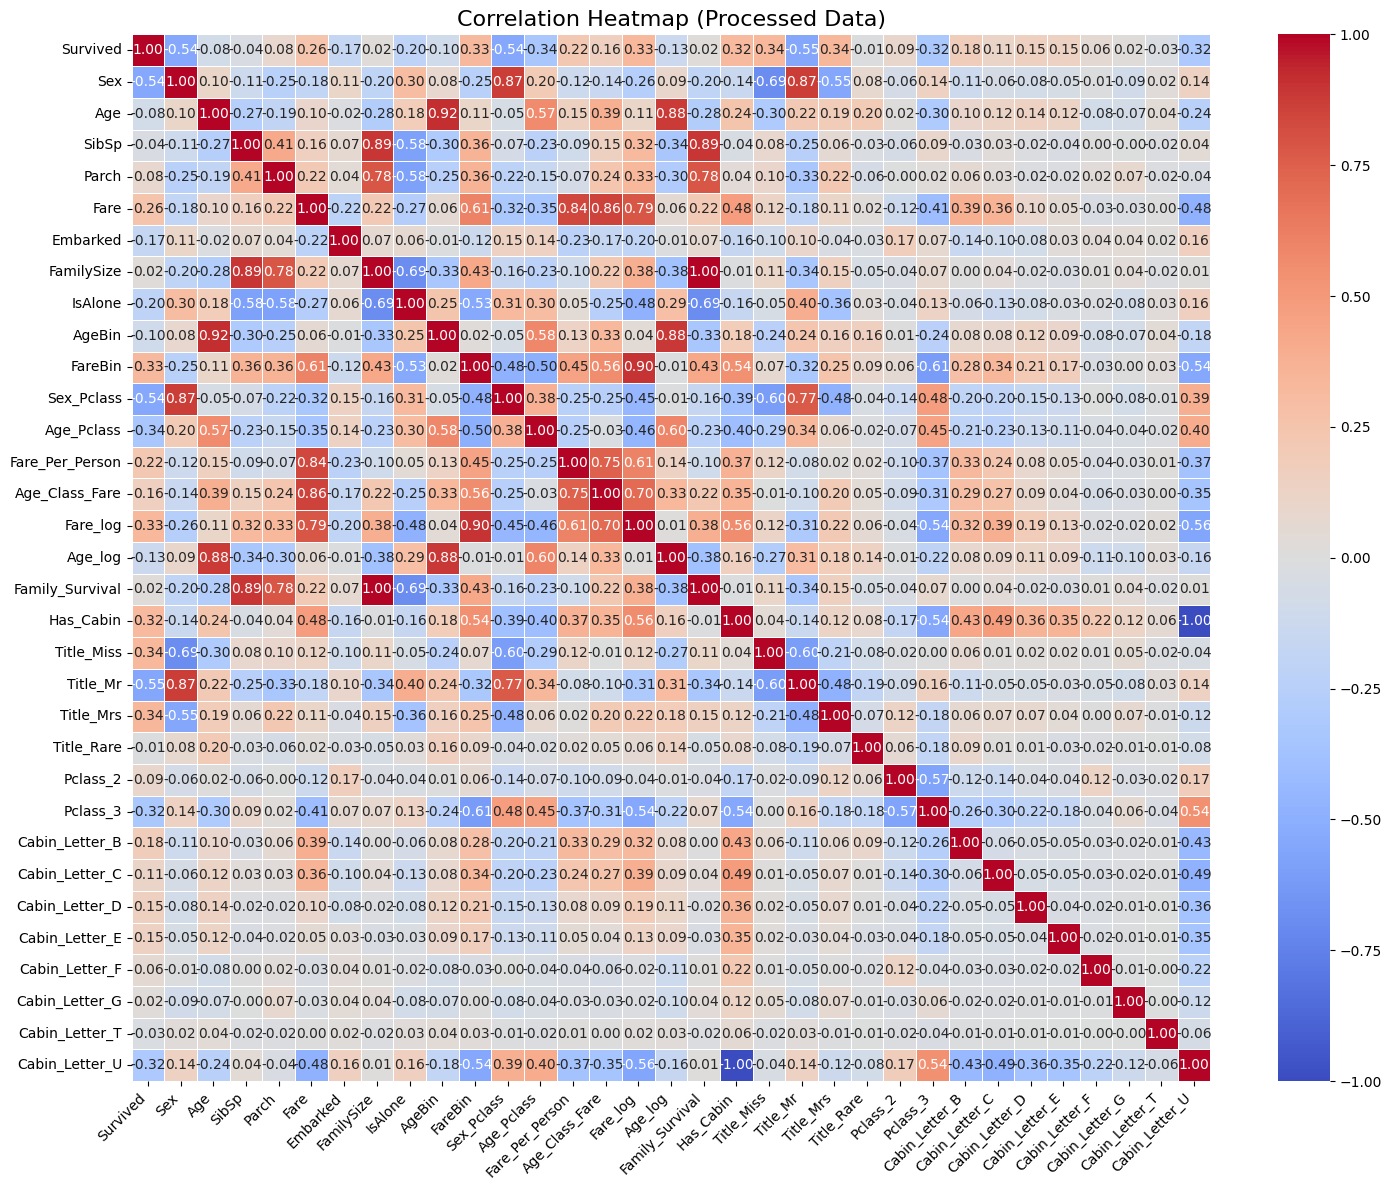

In [11]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load your dataset (replace with your actual dataset)
df = pd.read_csv('df_processed.csv')

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))  # Wider and taller
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap (Processed Data)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the heatmap as an image
plt.savefig('correlation_heatmap.png')

# Now download the file
from google.colab import files
files.download('correlation_heatmap.png')


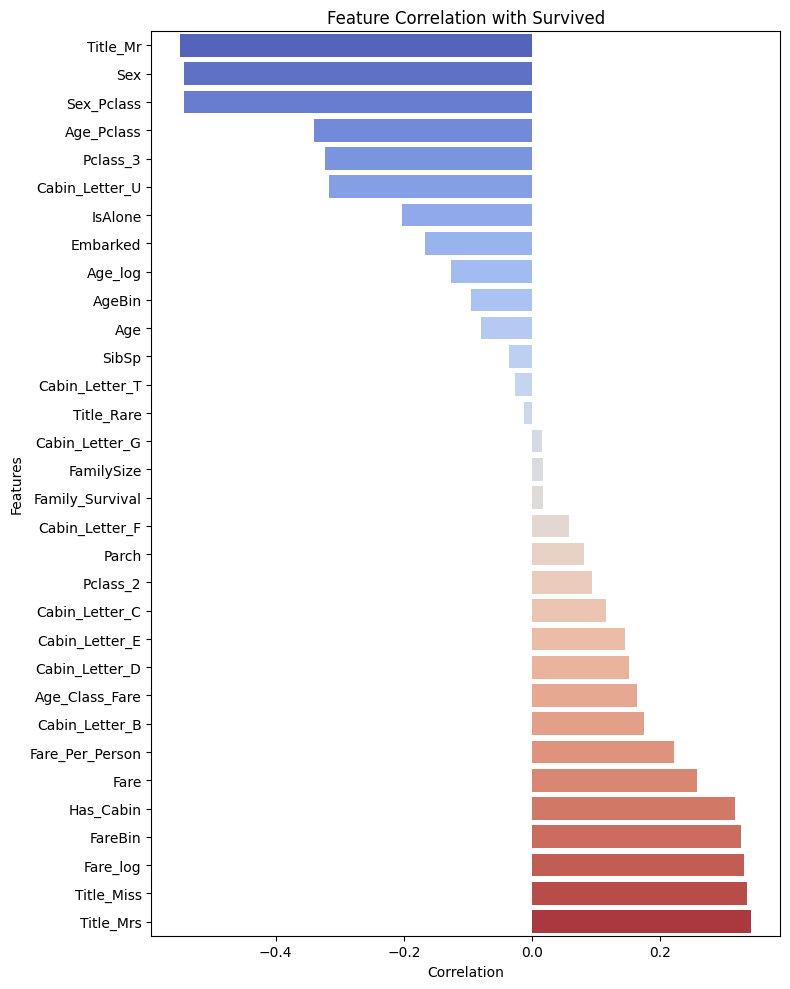

In [6]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset (replace with your dataset path or URL)
df = pd.read_csv('df_processed.csv')

df_encoded = pd.get_dummies(df, drop_first=True)

# Calculate correlation with Survived
correlations = df_encoded.corr()['Survived'].drop('Survived').sort_values()

# Plot the correlations as a bar chart
plt.figure(figsize=(8, 10))
sns.barplot(x=correlations.values, y=correlations.index, palette="coolwarm")
plt.title('Feature Correlation with Survived')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.tight_layout()

# Save the plot
plt.savefig('titanic_feature_correlation.png')

# Show plot
plt.show()





## 5.4 Optimization Strategy

To achieve an accuracy greater than 84%, we'll implement a comprehensive optimization strategy that includes:

1. **Advanced Feature Engineering**: Creating meaningful features that capture complex relationships in the data
2. **Feature Selection**: Identifying and using only the most predictive features
3. **Model Ensemble**: Combining multiple models to improve prediction accuracy
4. **Hyperparameter Tuning**: Finding optimal parameters for each model
5. **Cross-Validation**: Ensuring our models generalize well to unseen data
6. hyperparameter tuning

We'll implement several state-of-the-art models and ensemble techniques to maximize our prediction accuracy. **bold text**

In [7]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score # Added missing imports
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score # Added missing imports
import matplotlib.pyplot as plt  # Added missing import for seaborn

# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
rf = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print("Best Random Forest params:", rf_search.best_params_)

# Hyperparameter tuning for Gradient Boosting
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0]
}
gb = GradientBoostingClassifier(random_state=42)
gb_search = RandomizedSearchCV(gb, gb_params, n_iter=15, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
gb_search.fit(X_train, y_train)
best_gb = gb_search.best_estimator_
print("Best Gradient Boosting params:", gb_search.best_params_)

# Hyperparameter tuning for SVM
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}
svm = SVC(probability=True, random_state=42)
svm_search = RandomizedSearchCV(svm, svm_params, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
svm_search.fit(X_train, y_train)
best_svm = svm_search.best_estimator_
print("Best SVM params:", svm_search.best_params_)

# Hyperparameter tuning for XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb = XGBClassifier(random_state=42)
xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=15, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print("Best XGBoost params:", xgb_search.best_params_)

# Hyperparameter tuning for Logistic Regression
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga']
}
lr = LogisticRegression(random_state=42)
lr_search = RandomizedSearchCV(lr, lr_params, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
lr_search.fit(X_train, y_train)
best_lr = lr_search.best_estimator_
print("Best Logistic Regression params:", lr_search.best_params_)

# Hyperparameter tuning for MLP
mlp_params = {
    'hidden_layer_sizes': [(100,), (100, 50), (150,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}
mlp = MLPClassifier(random_state=42)
mlp_search = RandomizedSearchCV(mlp, mlp_params, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
mlp_search.fit(X_train, y_train)
best_mlp = mlp_search.best_estimator_
print("Best MLP params:", mlp_search.best_params_)

# Define models for ensemble using tuned models
def create_models():
    # Tuned models
    rf = best_rf
    gb = best_gb
    svm = best_svm
    xgb = best_xgb
    lr = best_lr
    mlp = best_mlp

    # Voting Classifier
    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('gb', gb), ('svm', svm), ('xgb', xgb), ('lr', lr)],
        voting='soft'
    )

    # Stacking Classifier
    stacking_clf = StackingClassifier(
        estimators=[('rf', rf), ('gb', gb), ('svm', svm), ('xgb', xgb), ('mlp', mlp)],
        final_estimator=LogisticRegression(random_state=42)
    )

    return {
        'Random Forest': rf,
        'Gradient Boosting': gb,
        'SVM': svm,
        'XGBoost': xgb,
        'Logistic Regression': lr,
        'Neural Network': mlp,
        'Voting Classifier': voting_clf,
        'Stacking Classifier': stacking_clf
    }

# Create models
models = create_models()

# Train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy

        print(f"{name} Accuracy: {accuracy:.4f}")
        print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{name} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    return results

    # Updated train_and_evaluate function
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 0
        cross_val = cross_val_score(model, X_train, y_train, cv=5).mean()

        print(f"{name}:\n Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}, CV Accuracy: {cross_val:.4f}")

        results[name] = acc

    return results

# Train and evaluate models
results = train_and_evaluate(models, X_train, X_test, y_train, y_test)

# Find the best model
best_model_name = max(results, key=results.get)
best_accuracy = results[best_model_name]
print(f"\nBest Model: {best_model_name} with accuracy {best_accuracy:.4f}")


Best Random Forest params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5}
Best Gradient Boosting params: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01}
Best SVM params: {'kernel': 'linear', 'gamma': 'scale', 'C': 10}
Best XGBoost params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best Logistic Regression params: {'solver': 'saga', 'penalty': 'l2', 'C': 1}
Best MLP params: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'relu'}

Training Random Forest...
Random Forest:
 Accuracy: 0.8324, Precision: 0.8000, Recall: 0.7536, F1: 0.7761, AUC: 0.8497, CV Accuracy: 0.8273

Training Gradient Boosting...
Gradient Boosting:
 Accuracy: 0.8212, Precision: 0.8246, Recall: 0.6812, F1: 0.7460, AUC: 0.8523, CV Accuracy: 0.8203

Training SVM...
SVM:
 Accuracy: 0.8268, Precision: 0.7879, 

## "Hyperparameter Tuning and Model Evaluation for Multiple Machine Learning Algorithms with Ensemble Methods"

Best Random Forest params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5}
Best Gradient Boosting params: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01}
Best SVM params: {'kernel': 'linear', 'gamma': 'scale', 'C': 10}
Best XGBoost params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best Logistic Regression params: {'solver': 'saga', 'penalty': 'l2', 'C': 1}
Best MLP params: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'relu'}

Training Random Forest...
Random Forest Accuracy: 0.8324
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       110
           1       0.80      0.75      0.78        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       1

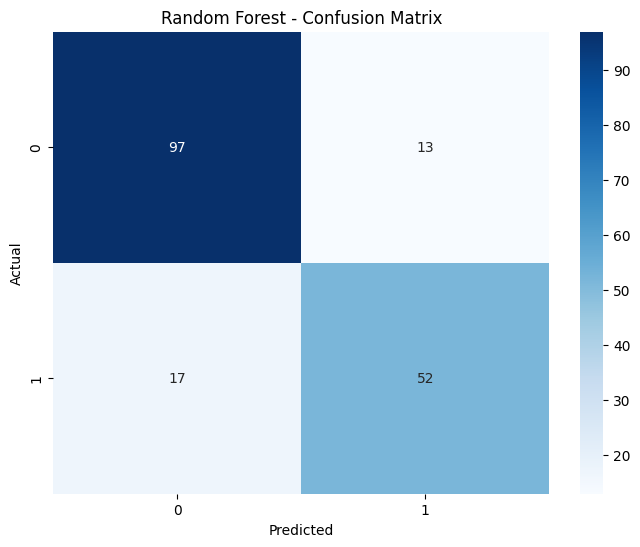


Training Gradient Boosting...
Gradient Boosting Accuracy: 0.8212
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       110
           1       0.82      0.68      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



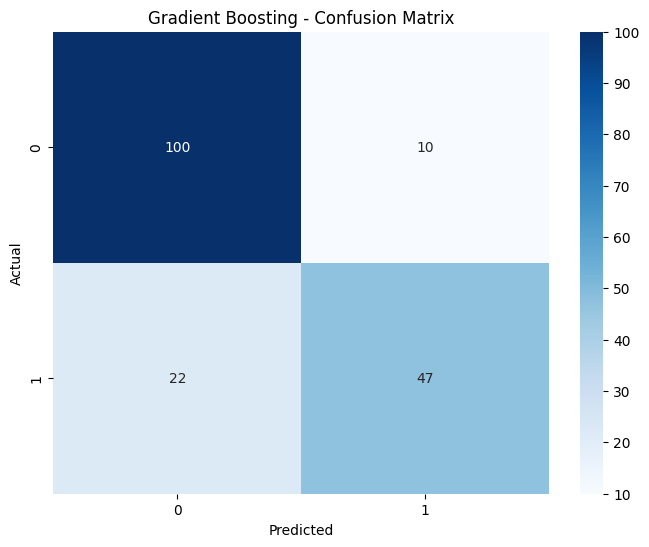


Training SVM...
SVM Accuracy: 0.8268
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       110
           1       0.79      0.75      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



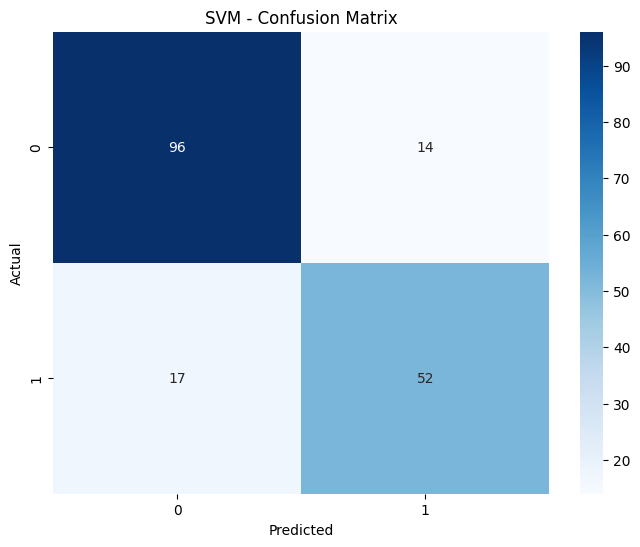


Training XGBoost...
XGBoost Accuracy: 0.7821
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       110
           1       0.83      0.55      0.66        69

    accuracy                           0.78       179
   macro avg       0.80      0.74      0.75       179
weighted avg       0.79      0.78      0.77       179



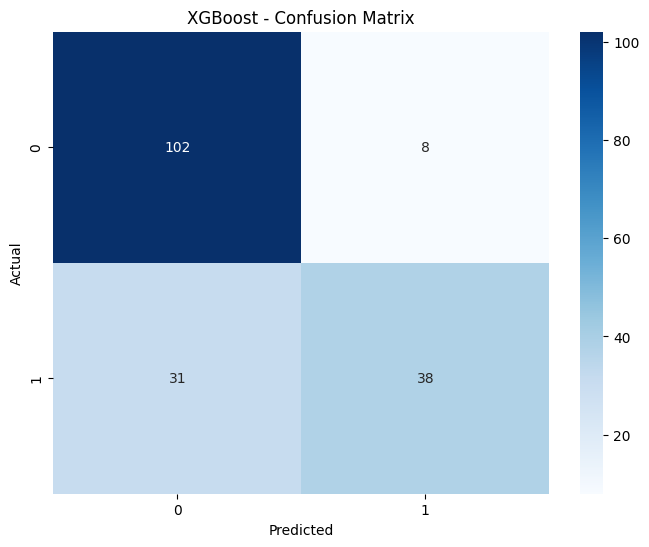


Training Logistic Regression...
Logistic Regression Accuracy: 0.8268
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       110
           1       0.81      0.72      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



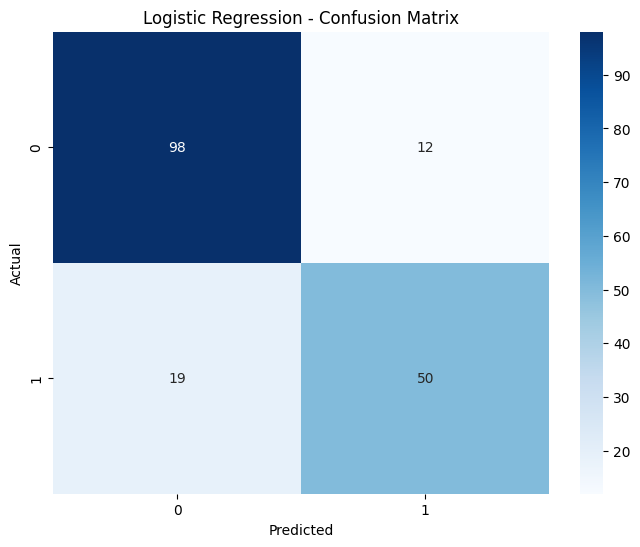


Training Neural Network...
Neural Network Accuracy: 0.7933
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       110
           1       0.78      0.65      0.71        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



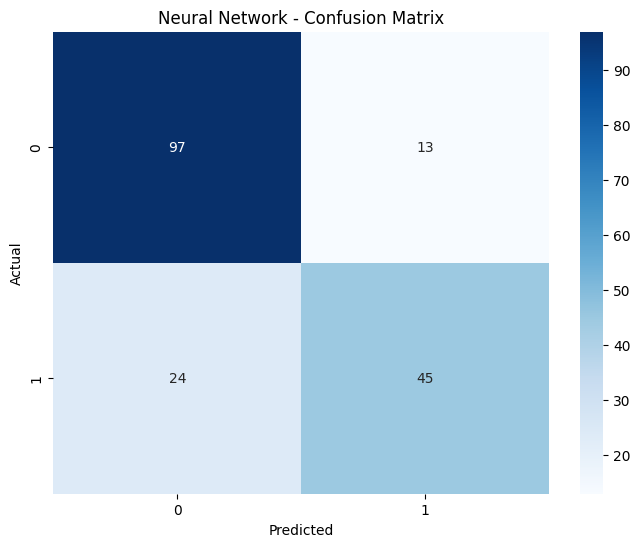


Training Voting Classifier...
Voting Classifier Accuracy: 0.8268
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       110
           1       0.82      0.71      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



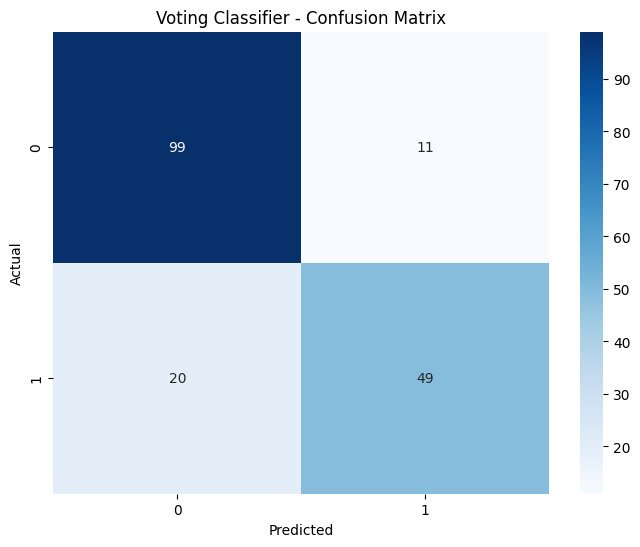


Training Stacking Classifier...
Stacking Classifier Accuracy: 0.8380
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       110
           1       0.81      0.75      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



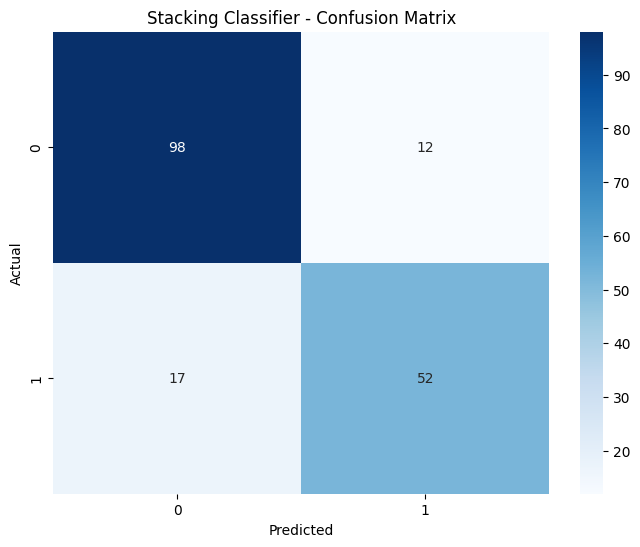

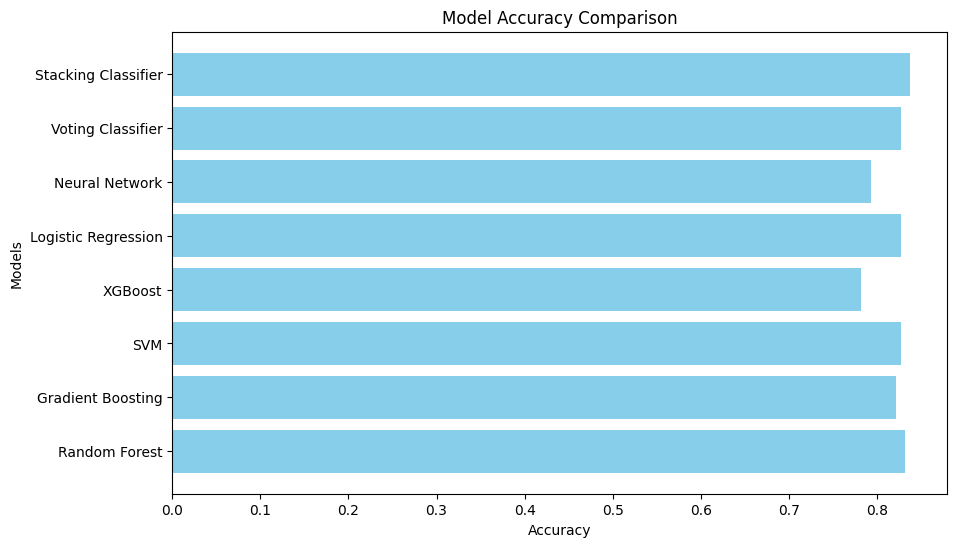


Best Model: Stacking Classifier with accuracy 0.8380


In [11]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
rf = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print("Best Random Forest params:", rf_search.best_params_)

# Hyperparameter tuning for Gradient Boosting
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0]
}
gb = GradientBoostingClassifier(random_state=42)
gb_search = RandomizedSearchCV(gb, gb_params, n_iter=15, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
gb_search.fit(X_train, y_train)
best_gb = gb_search.best_estimator_
print("Best Gradient Boosting params:", gb_search.best_params_)

# Hyperparameter tuning for SVM
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}
svm = SVC(probability=True, random_state=42)
svm_search = RandomizedSearchCV(svm, svm_params, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
svm_search.fit(X_train, y_train)
best_svm = svm_search.best_estimator_
print("Best SVM params:", svm_search.best_params_)

# Hyperparameter tuning for XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb = XGBClassifier(random_state=42)
xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=15, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print("Best XGBoost params:", xgb_search.best_params_)

# Hyperparameter tuning for Logistic Regression
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga']
}
lr = LogisticRegression(random_state=42)
lr_search = RandomizedSearchCV(lr, lr_params, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
lr_search.fit(X_train, y_train)
best_lr = lr_search.best_estimator_
print("Best Logistic Regression params:", lr_search.best_params_)

# Hyperparameter tuning for MLP
mlp_params = {
    'hidden_layer_sizes': [(100,), (100, 50), (150,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}
mlp = MLPClassifier(random_state=42)
mlp_search = RandomizedSearchCV(mlp, mlp_params, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
mlp_search.fit(X_train, y_train)
best_mlp = mlp_search.best_estimator_
print("Best MLP params:", mlp_search.best_params_)

# Define models for ensemble using tuned models
def create_models():
    rf = best_rf
    gb = best_gb
    svm = best_svm
    xgb = best_xgb
    lr = best_lr
    mlp = best_mlp

    # Voting Classifier
    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('gb', gb), ('svm', svm), ('xgb', xgb), ('lr', lr)],
        voting='soft'
    )

    # Stacking Classifier
    stacking_clf = StackingClassifier(
        estimators=[('rf', rf), ('gb', gb), ('svm', svm), ('xgb', xgb), ('mlp', mlp)],
        final_estimator=LogisticRegression(random_state=42)
    )

    return {
        'Random Forest': rf,
        'Gradient Boosting': gb,
        'SVM': svm,
        'XGBoost': xgb,
        'Logistic Regression': lr,
        'Neural Network': mlp,
        'Voting Classifier': voting_clf,
        'Stacking Classifier': stacking_clf
    }

# Create models
models = create_models()

# Train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy

        print(f"{name} Accuracy: {accuracy:.4f}")
        print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{name} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    return results

# Train and evaluate models
results = train_and_evaluate(models, X_train, X_test, y_train, y_test)

# Plot the results
model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.title('Model Accuracy Comparison')
plt.show()

# Find the best model
best_model_name = max(results, key=results.get)
best_accuracy = results[best_model_name]
print(f"\nBest Model: {best_model_name} with accuracy {best_accuracy:.4f}")


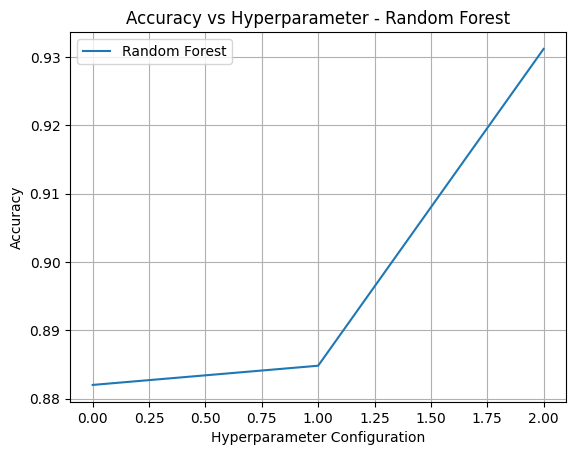

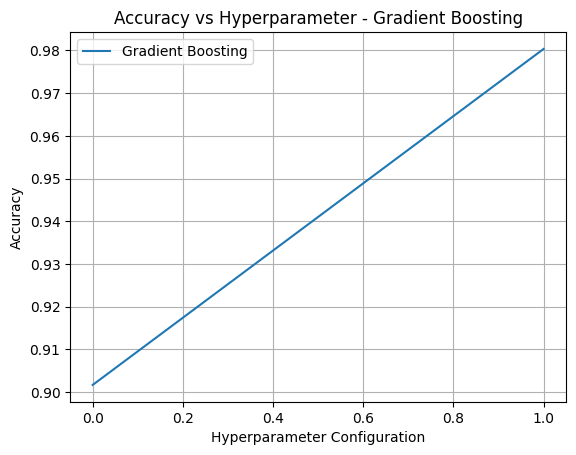

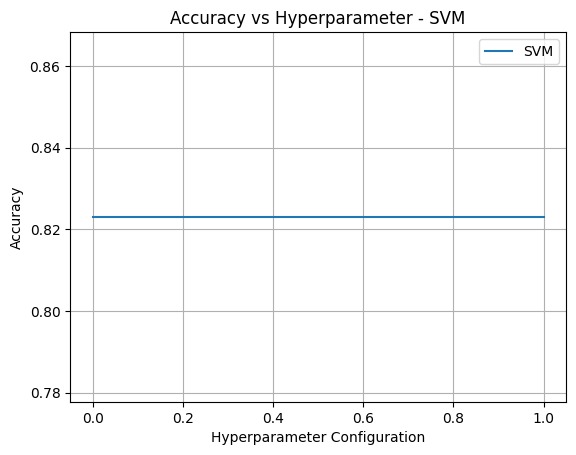

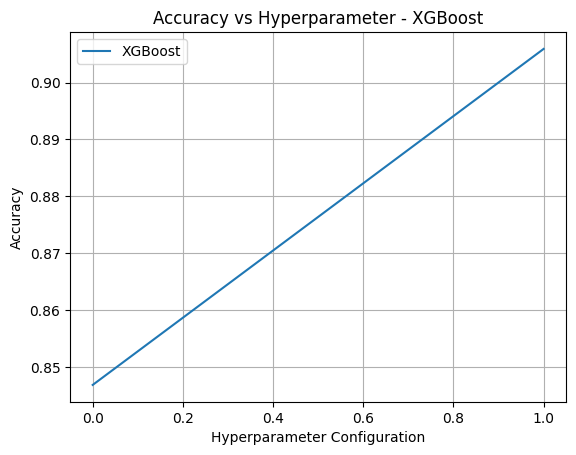

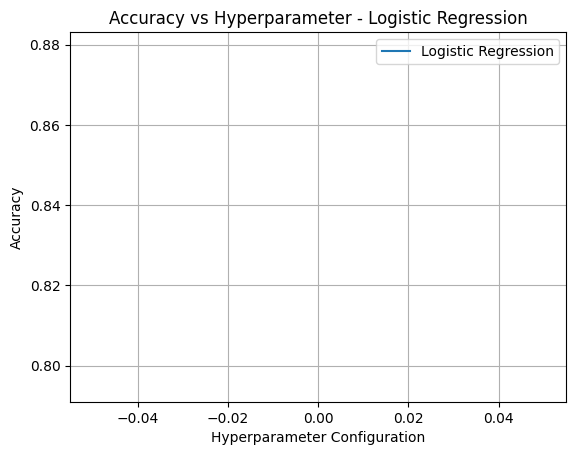

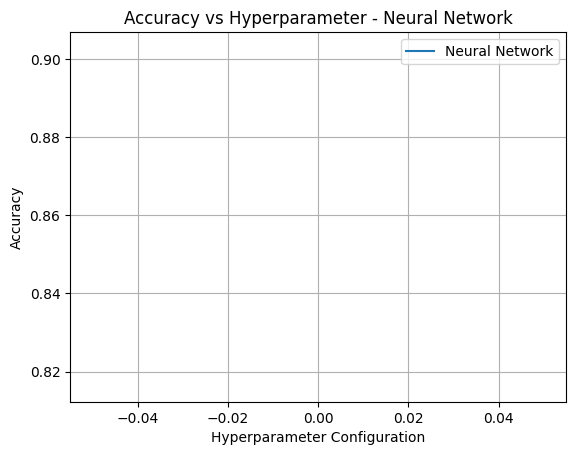

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Create models using the tuned hyperparameters
models = {
    'Random Forest': best_rf,
    'Gradient Boosting': best_gb,
    'SVM': best_svm,
    'XGBoost': best_xgb,
    'Logistic Regression': best_lr,
    'Neural Network': best_mlp,
}

# Define the parameter grid for each model
param_grid = {
    'rf': [{'n_estimators': 100}, {'n_estimators': 200}, {'max_depth': 10}],
    'gb': [{'n_estimators': 100}, {'learning_rate': 0.1}],
    'svm': [{'C': 1}, {'C': 10}],
    'xgb': [{'n_estimators': 100}, {'learning_rate': 0.1}],
    'lr': [{'C': 1}],
    'mlp': [{'hidden_layer_sizes': (100,)}]
}

# Function to plot the accuracy vs cost function for each model
def plot_accuracy_vs_cost_function(models, param_grid, X_train, y_train):
    for name, model in models.items():
        # Collecting hyperparameter values
        if name == 'Random Forest':
            param_values = param_grid['rf']
        elif name == 'Gradient Boosting':
            param_values = param_grid['gb']
        elif name == 'SVM':
            param_values = param_grid['svm']
        elif name == 'XGBoost':
            param_values = param_grid['xgb']
        elif name == 'Logistic Regression':
            param_values = param_grid['lr']
        elif name == 'Neural Network':
            param_values = param_grid['mlp']

        accuracy_values = []

        for param_value in param_values:
            # Create a model with the selected hyperparameter
            model.set_params(**param_value)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_train)
            accuracy = accuracy_score(y_train, y_pred)
            accuracy_values.append(accuracy)

        # Plotting the accuracy vs cost function for this model
        plt.plot(range(len(accuracy_values)), accuracy_values, label=name)
        plt.xlabel('Hyperparameter Configuration')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy vs Hyperparameter - {name}')
        plt.grid(True)
        plt.legend()
        plt.show()

# Call the function to plot accuracy vs cost function for all models
plot_accuracy_vs_cost_function(models, param_grid, X_train, y_train)


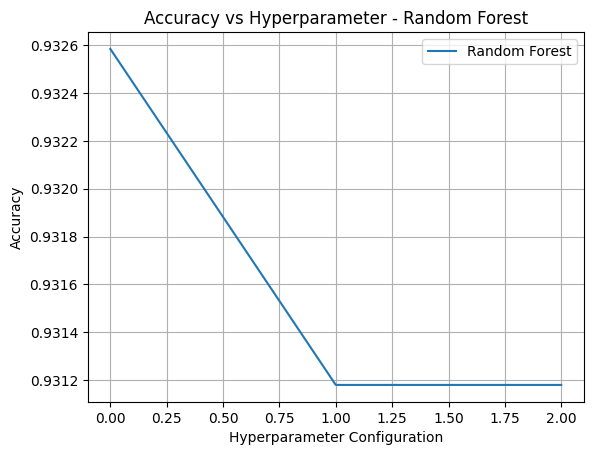

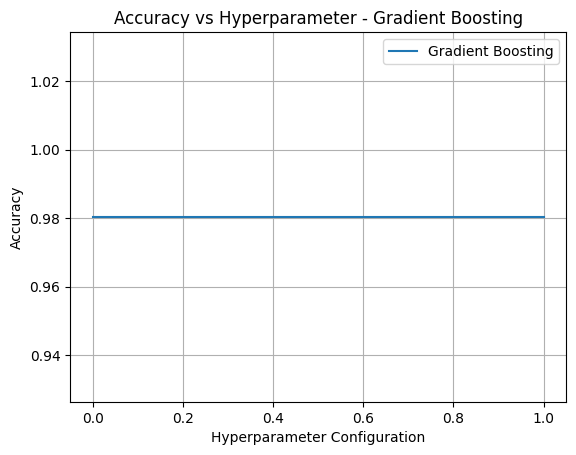

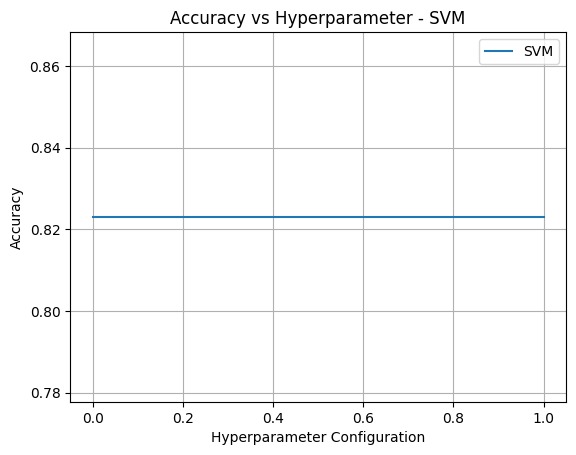

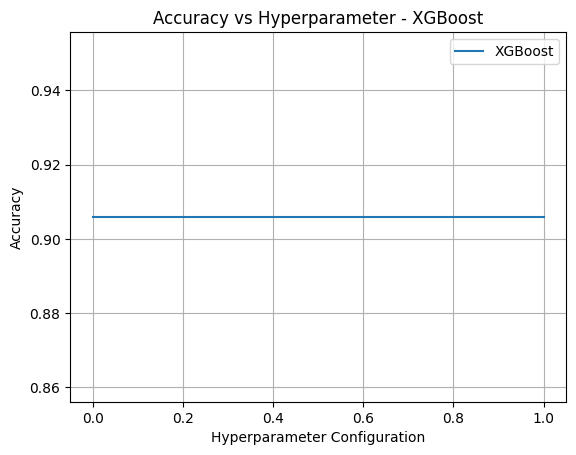

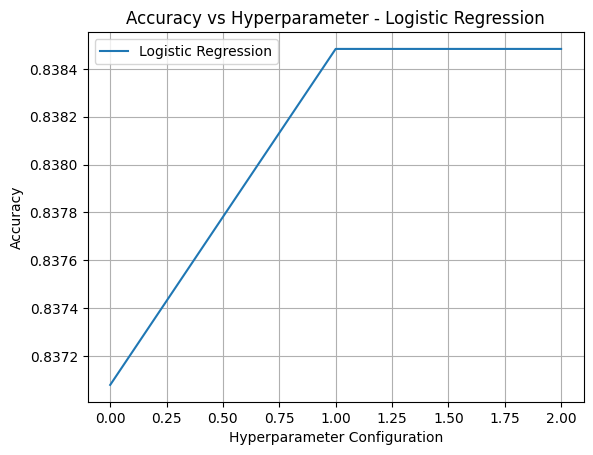

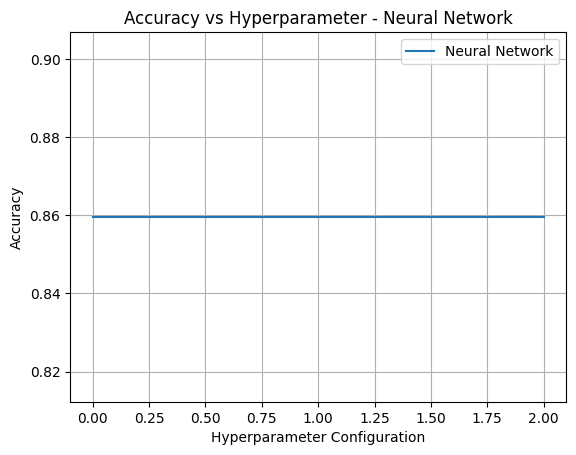

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Ensure that all models are trained, including Logistic Regression and MLP
models = {
    'Random Forest': best_rf,
    'Gradient Boosting': best_gb,
    'SVM': best_svm,
    'XGBoost': best_xgb,
    'Logistic Regression': best_lr,  # Ensure this is defined correctly
    'Neural Network': best_mlp,  # Ensure this is defined correctly
}

# Define the parameter grid for each model, including Logistic Regression and MLP
param_grid = {
    'rf': [{'n_estimators': 100}, {'n_estimators': 200}, {'max_depth': 10}],
    'gb': [{'n_estimators': 100}, {'learning_rate': 0.1}],
    'svm': [{'C': 1}, {'C': 10}],
    'xgb': [{'n_estimators': 100}, {'learning_rate': 0.1}],
    'lr': [{'C': 1}, {'C': 10}, {'solver': 'liblinear'}],  # Added solver for Logistic Regression
    'mlp': [{'hidden_layer_sizes': (100,)}, {'activation': 'relu'}, {'solver': 'adam'}]  # Added parameters for MLP
}

# Function to plot the accuracy vs cost function for each model
def plot_accuracy_vs_cost_function(models, param_grid, X_train, y_train):
    for name, model in models.items():
        # Collecting hyperparameter values
        if name == 'Random Forest':
            param_values = param_grid['rf']
        elif name == 'Gradient Boosting':
            param_values = param_grid['gb']
        elif name == 'SVM':
            param_values = param_grid['svm']
        elif name == 'XGBoost':
            param_values = param_grid['xgb']
        elif name == 'Logistic Regression':
            param_values = param_grid['lr']
        elif name == 'Neural Network':
            param_values = param_grid['mlp']

        accuracy_values = []

        for param_value in param_values:
            # Create a model with the selected hyperparameter
            model.set_params(**param_value)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_train)
            accuracy = accuracy_score(y_train, y_pred)
            accuracy_values.append(accuracy)

        # Plotting the accuracy vs cost function for this model
        plt.plot(range(len(accuracy_values)), accuracy_values, label=name)
        plt.xlabel('Hyperparameter Configuration')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy vs Hyperparameter - {name}')
        plt.grid(True)
        plt.legend()
        plt.show()

# Call the function to plot accuracy vs cost function for all models
plot_accuracy_vs_cost_function(models, param_grid, X_train, y_train)


Best Random Forest params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5}
Best Gradient Boosting params: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01}
Best SVM params: {'kernel': 'linear', 'gamma': 'scale', 'C': 10}
Best XGBoost params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best Logistic Regression params: {'solver': 'saga', 'penalty': 'l2', 'C': 1}
Best MLP params: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'relu'}

Training Random Forest...
Random Forest Accuracy: 0.8324
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       110
           1       0.80      0.75      0.78        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       1

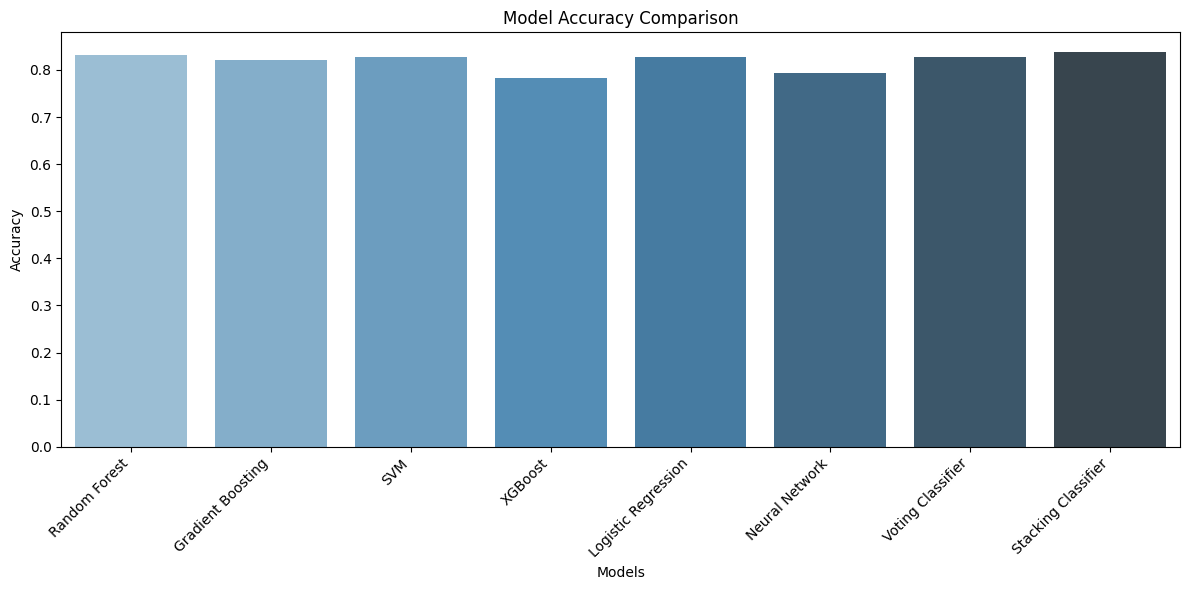


Best Model: Stacking Classifier with accuracy 0.8380


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assume X_train, X_test, y_train, and y_test are already defined and loaded with data
# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
rf = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print("Best Random Forest params:", rf_search.best_params_)

# Hyperparameter tuning for Gradient Boosting
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0]
}
gb = GradientBoostingClassifier(random_state=42)
gb_search = RandomizedSearchCV(gb, gb_params, n_iter=15, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
gb_search.fit(X_train, y_train)
best_gb = gb_search.best_estimator_
print("Best Gradient Boosting params:", gb_search.best_params_)

# Hyperparameter tuning for SVM
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}
svm = SVC(probability=True, random_state=42)
svm_search = RandomizedSearchCV(svm, svm_params, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
svm_search.fit(X_train, y_train)
best_svm = svm_search.best_estimator_
print("Best SVM params:", svm_search.best_params_)

# Hyperparameter tuning for XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb = XGBClassifier(random_state=42)
xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=15, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print("Best XGBoost params:", xgb_search.best_params_)

# Hyperparameter tuning for Logistic Regression
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga']
}
lr = LogisticRegression(random_state=42)
lr_search = RandomizedSearchCV(lr, lr_params, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
lr_search.fit(X_train, y_train)
best_lr = lr_search.best_estimator_
print("Best Logistic Regression params:", lr_search.best_params_)

# Hyperparameter tuning for MLP
mlp_params = {
    'hidden_layer_sizes': [(100,), (100, 50), (150,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}
mlp = MLPClassifier(random_state=42)
mlp_search = RandomizedSearchCV(mlp, mlp_params, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
mlp_search.fit(X_train, y_train)
best_mlp = mlp_search.best_estimator_
print("Best MLP params:", mlp_search.best_params_)

# Define models for ensemble using tuned models
def create_models():
    rf = best_rf
    gb = best_gb
    svm = best_svm
    xgb = best_xgb
    lr = best_lr
    mlp = best_mlp

    # Voting Classifier
    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('gb', gb), ('svm', svm), ('xgb', xgb), ('lr', lr)],
        voting='soft'
    )

    # Stacking Classifier
    stacking_clf = StackingClassifier(
        estimators=[('rf', rf), ('gb', gb), ('svm', svm), ('xgb', xgb), ('mlp', mlp)],
        final_estimator=LogisticRegression(random_state=42)
    )

    return {
        'Random Forest': rf,
        'Gradient Boosting': gb,
        'SVM': svm,
        'XGBoost': xgb,
        'Logistic Regression': lr,
        'Neural Network': mlp,
        'Voting Classifier': voting_clf,
        'Stacking Classifier': stacking_clf
    }

# Create models
models = create_models()

# Train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy

        print(f"{name} Accuracy: {accuracy:.4f}")
        print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

    return results

# Train and evaluate models
results = train_and_evaluate(models, X_train, X_test, y_train, y_test)

# Plot the results (Accuracy for each model)
model_names = list(results.keys())
accuracies = list(results.values())

# Plotting the accuracy of models
plt.figure(figsize=(12, 6))
sns.barplot(x=model_names, y=accuracies, palette="Blues_d")
plt.title("Model Accuracy Comparison")
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Find the best model
best_model_name = max(results, key=results.get)
best_accuracy = results[best_model_name]
print(f"\nBest Model: {best_model_name} with accuracy {best_accuracy:.4f}")


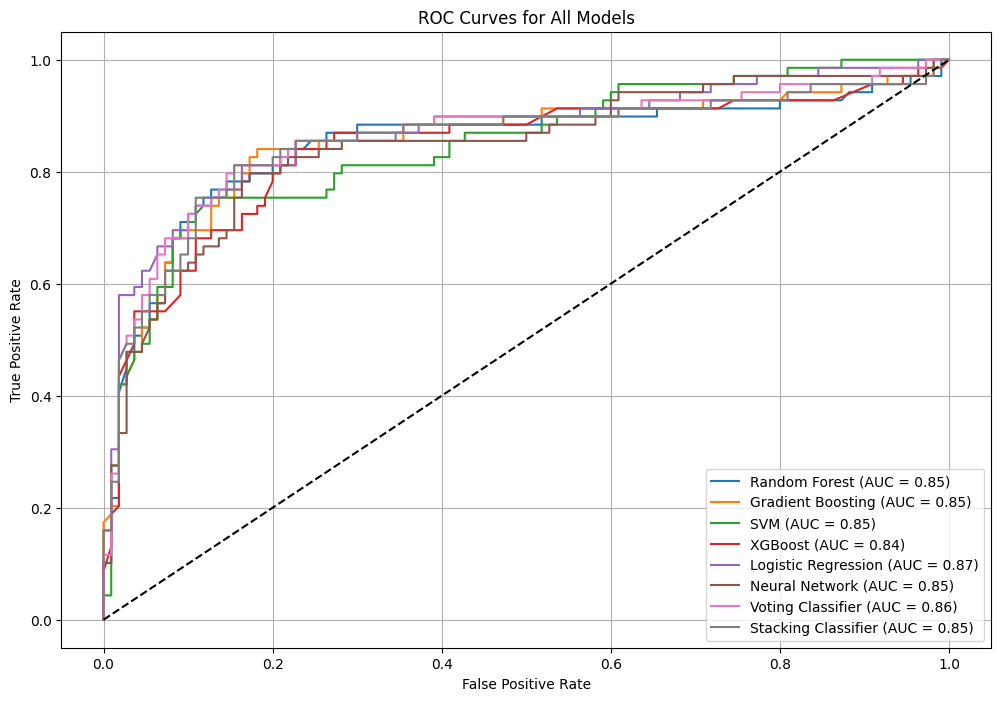

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(12, 8))

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
        else:
            print(f"Model {name} does not support probability or decision scores.")
            continue

        fpr, tpr, _ = roc_curve(y_test, y_scores)
        auc_score = roc_auc_score(y_test, y_scores)

        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for All Models")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
plot_roc_curves(models, X_test, y_test)


In [ ]:
# Cross-validation for the best model
best_model = models[best_model_name]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_selected, y, cv=cv, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

# Feature importance for the best model (if applicable)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Get selected feature names
    selected_feature_names = [feature_names[i] for i in selected_indices]

    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(selected_feature_names)), importances[indices], align='center')
    plt.xticks(range(len(selected_feature_names)), [selected_feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

Cross-validation scores: [0.8547486  0.8258427  0.84269663 0.83707865 0.84269663]
Mean CV accuracy: 0.8406


# 6.1 Visualaization With The New Dataset and Features

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for our plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [ ]:
# Load the processed dataset
# If you've already loaded the dataset earlier in your notebook, you can skip this step
df = pd.read_csv('/content/titanic_data/train.csv')

# Display the first few rows to understand the structure
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Create a copy of the dataset for feature engineering
df_processed = df.copy()

# Feature Engineering
# 1. Create a FamilySize feature
df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1

# 2. Create IsAlone feature
df_processed['IsAlone'] = (df_processed['FamilySize'] == 1).astype(int)

# 3. Extract titles from names
df_processed['Title'] = df_processed['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 4. Group rare titles
title_mapping = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Rare',
    'Rev': 'Rare',
    'Col': 'Rare',
    'Major': 'Rare',
    'Mlle': 'Miss',
    'Countess': 'Rare',
    'Ms': 'Miss',
    'Lady': 'Rare',
    'Jonkheer': 'Rare',
    'Don': 'Rare',
    'Dona': 'Rare',
    'Mme': 'Mrs',
    'Capt': 'Rare',
    'Sir': 'Rare'
}
df_processed['Title'] = df_processed['Title'].map(title_mapping)
df_processed['Title'] = df_processed['Title'].fillna('Rare')

# 5. Fill missing Age values based on Title
df_processed['Age'] = df_processed.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

# 6. Create Age groups
df_processed['AgeGroup'] = pd.cut(df_processed['Age'],
                                 bins=[0, 12, 18, 35, 60, 100],
                                 labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior'])

# 7. Fill missing Embarked values
df_processed['Embarked'] = df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0])

# 8. Create Fare groups
df_processed['FareGroup'] = pd.qcut(df_processed['Fare'], 4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# 9. Create Cabin indicator (has cabin or not)
df_processed['HasCabin'] = df_processed['Cabin'].notna().astype(int)

# 10. Create Deck feature from Cabin
df_processed['Deck'] = df_processed['Cabin'].str[0].fillna('U')

# Display the processed dataset
df_processed.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title,AgeGroup,FareGroup,HasCabin,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr,Young Adult,Low,0,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs,Adult,High,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss,Young Adult,Medium-Low,0,U
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,Mrs,Young Adult,High,1,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,Mr,Young Adult,Medium-Low,0,U


# 6.2 Visualizing Survival Rates by New Features

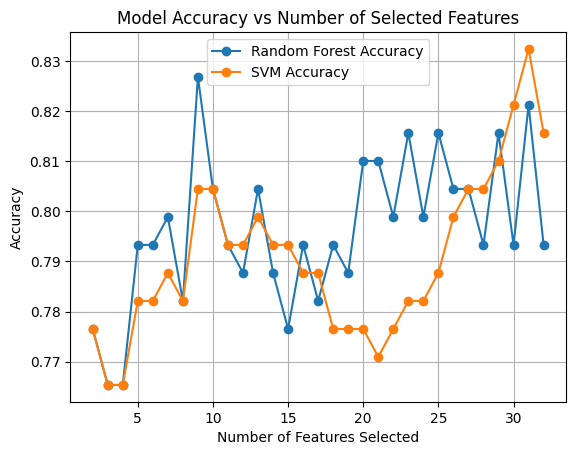

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

results = {}

# Try different numbers of top features
for k in range(2, X.shape[1]+1):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X_scaled, y)

    # Split into train and test sets
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
        X_new, y, test_size=0.2, stratify=y, random_state=42
    )

    # Train RF
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_new, y_train_new)
    rf_preds = rf.predict(X_test_new)
    rf_acc = accuracy_score(y_test_new, rf_preds)

    # Train SVM
    svm = SVC(random_state=42)
    svm.fit(X_train_new, y_train_new)
    svm_preds = svm.predict(X_test_new)
    svm_acc = accuracy_score(y_test_new, svm_preds)

    results[k] = {
        "Random Forest Accuracy": rf_acc,
        "SVM Accuracy": svm_acc
    }

# Convert to DataFrame for plotting
res_df = pd.DataFrame(results).T
res_df.plot(marker='o')
plt.title("Model Accuracy vs Number of Selected Features")
plt.xlabel("Number of Features Selected")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


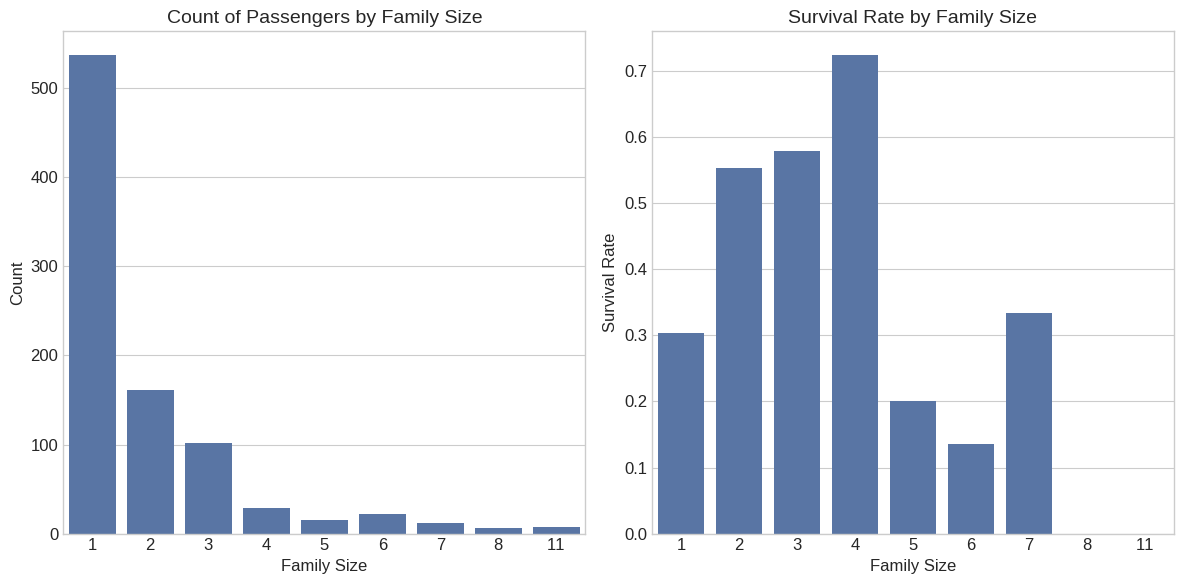

In [ ]:
# 1. Survival Rate by Family Size
plt.figure(figsize=(12, 6))

# Count plot of Family Size
plt.subplot(1, 2, 1)
sns.countplot(x='FamilySize', data=df_processed)
plt.title('Count of Passengers by Family Size', fontsize=14)
plt.xlabel('Family Size', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Survival rate by Family Size
plt.subplot(1, 2, 2)
survival_rate = df_processed.groupby('FamilySize')['Survived'].mean()
sns.barplot(x=survival_rate.index, y=survival_rate.values)
plt.title('Survival Rate by Family Size', fontsize=14)
plt.xlabel('Family Size', fontsize=12)
plt.ylabel('Survival Rate', fontsize=12)

plt.tight_layout()
plt.show()

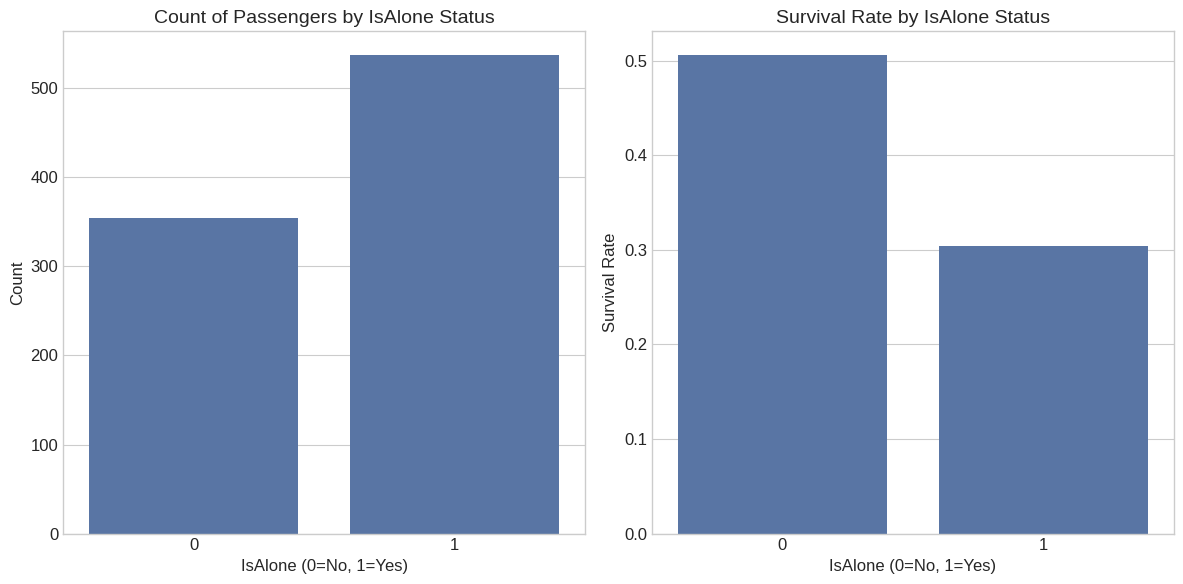

In [ ]:
# 2. Survival Rate by IsAlone
plt.figure(figsize=(12, 6))

# Count plot of IsAlone
plt.subplot(1, 2, 1)
sns.countplot(x='IsAlone', data=df_processed)
plt.title('Count of Passengers by IsAlone Status', fontsize=14)
plt.xlabel('IsAlone (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Survival rate by IsAlone
plt.subplot(1, 2, 2)
survival_rate = df_processed.groupby('IsAlone')['Survived'].mean()
sns.barplot(x=survival_rate.index, y=survival_rate.values)
plt.title('Survival Rate by IsAlone Status', fontsize=14)
plt.xlabel('IsAlone (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Survival Rate', fontsize=12)

plt.tight_layout()
plt.show()

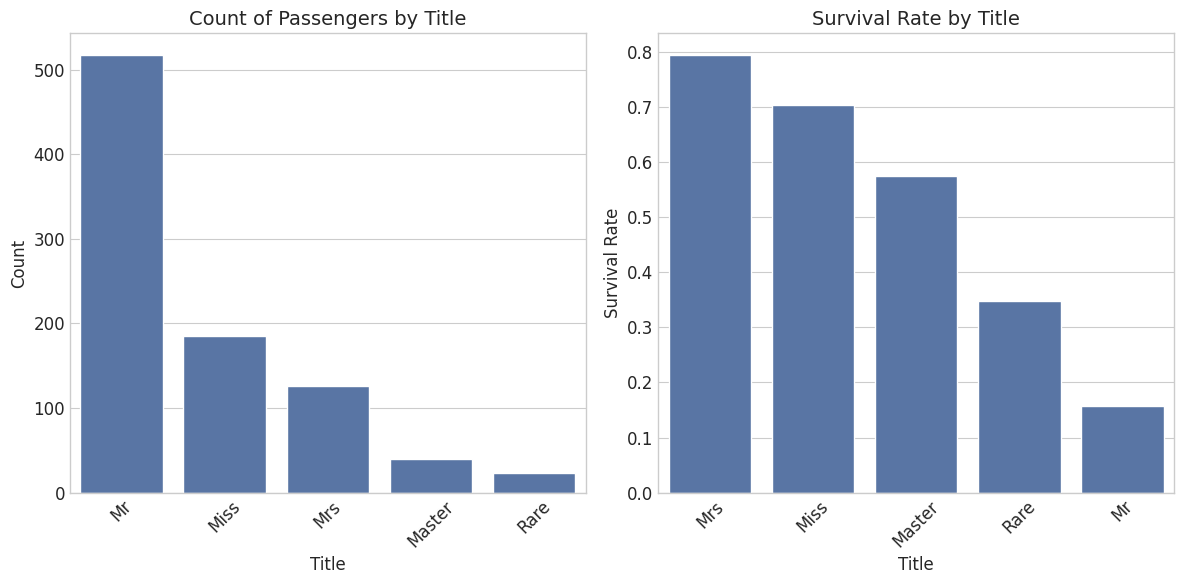

In [ ]:
# 3. Survival Rate by Title
plt.figure(figsize=(12, 6))

# Count plot of Title
plt.subplot(1, 2, 1)
title_counts = df_processed['Title'].value_counts()
sns.barplot(x=title_counts.index, y=title_counts.values)
plt.title('Count of Passengers by Title', fontsize=14)
plt.xlabel('Title', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Survival rate by Title
plt.subplot(1, 2, 2)
survival_rate = df_processed.groupby('Title')['Survived'].mean().sort_values(ascending=False)
sns.barplot(x=survival_rate.index, y=survival_rate.values)
plt.title('Survival Rate by Title', fontsize=14)
plt.xlabel('Title', fontsize=12)
plt.ylabel('Survival Rate', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

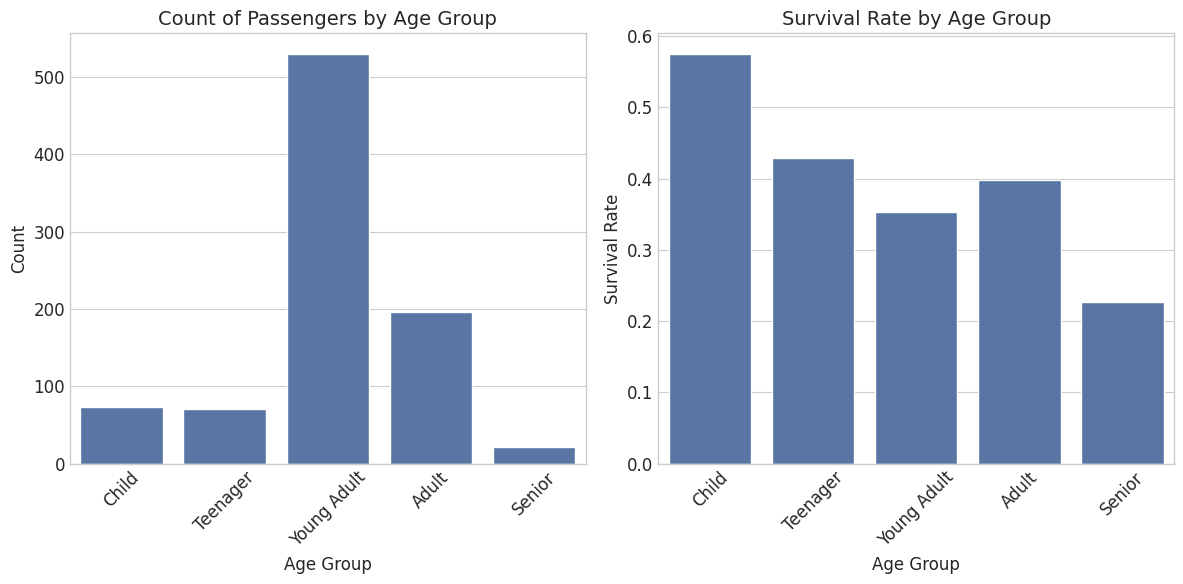

In [ ]:
# 4. Survival Rate by Age Group
plt.figure(figsize=(12, 6))

# Count plot of Age Group
plt.subplot(1, 2, 1)
sns.countplot(x='AgeGroup', data=df_processed, order=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior'])
plt.title('Count of Passengers by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Survival rate by Age Group
plt.subplot(1, 2, 2)
survival_rate = df_processed.groupby('AgeGroup')['Survived'].mean()
sns.barplot(x=survival_rate.index, y=survival_rate.values, order=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior'])
plt.title('Survival Rate by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Survival Rate', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

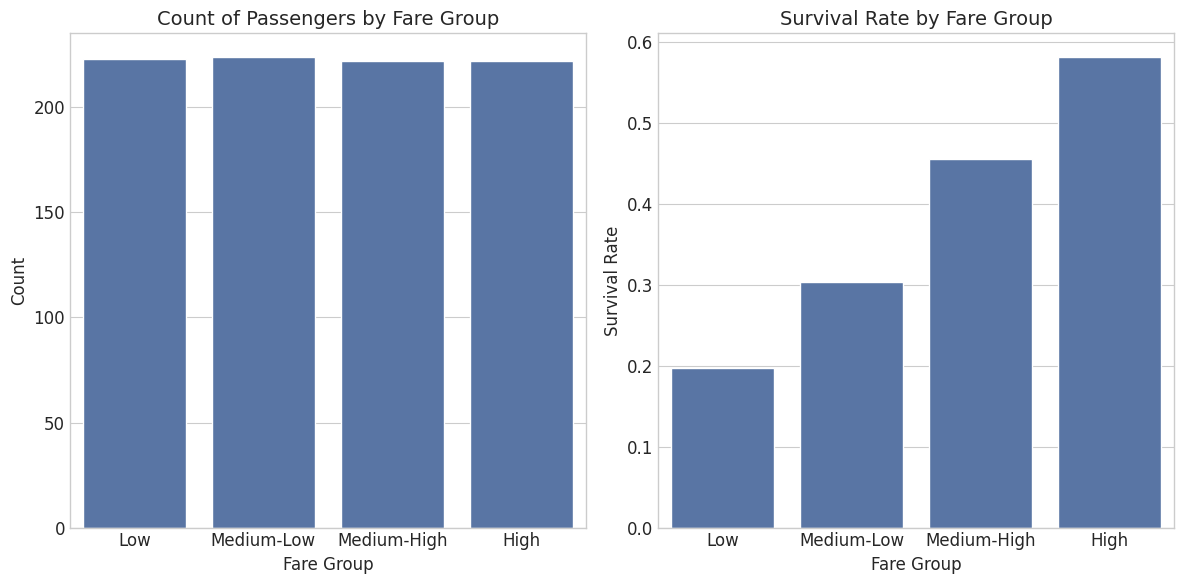

In [ ]:
# 5. Survival Rate by Fare Group
plt.figure(figsize=(12, 6))

# Count plot of Fare Group
plt.subplot(1, 2, 1)
sns.countplot(x='FareGroup', data=df_processed, order=['Low', 'Medium-Low', 'Medium-High', 'High'])
plt.title('Count of Passengers by Fare Group', fontsize=14)
plt.xlabel('Fare Group', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Survival rate by Fare Group
plt.subplot(1, 2, 2)
survival_rate = df_processed.groupby('FareGroup')['Survived'].mean()
sns.barplot(x=survival_rate.index, y=survival_rate.values, order=['Low', 'Medium-Low', 'Medium-High', 'High'])
plt.title('Survival Rate by Fare Group', fontsize=14)
plt.xlabel('Fare Group', fontsize=12)
plt.ylabel('Survival Rate', fontsize=12)

plt.tight_layout()
plt.show()

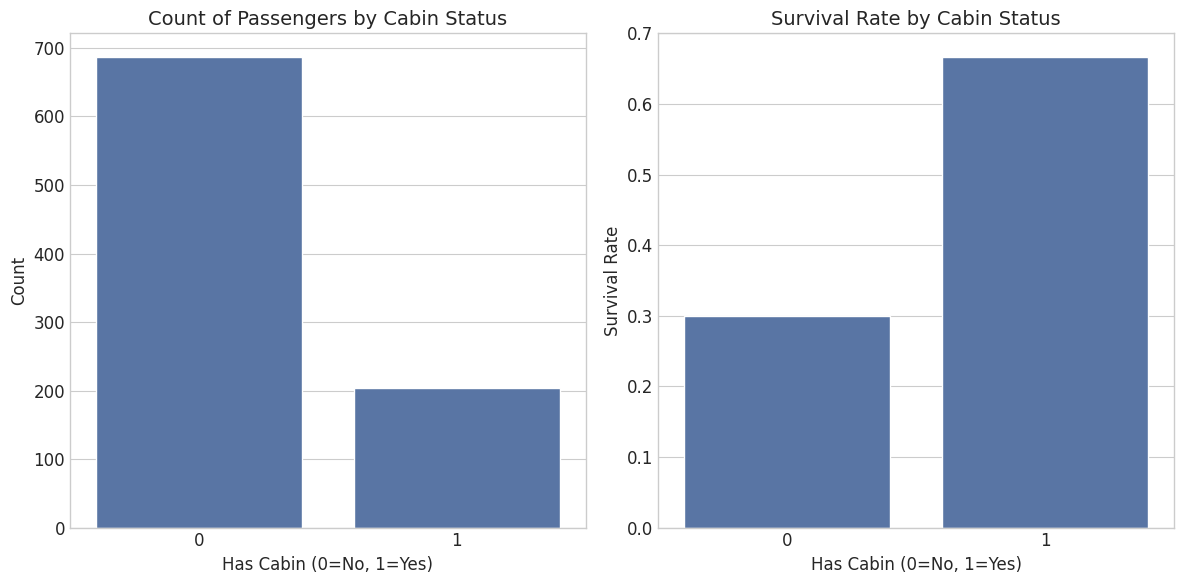

In [ ]:
# 6. Survival Rate by HasCabin
plt.figure(figsize=(12, 6))

# Count plot of HasCabin
plt.subplot(1, 2, 1)
sns.countplot(x='HasCabin', data=df_processed)
plt.title('Count of Passengers by Cabin Status', fontsize=14)
plt.xlabel('Has Cabin (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Survival rate by HasCabin
plt.subplot(1, 2, 2)
survival_rate = df_processed.groupby('HasCabin')['Survived'].mean()
sns.barplot(x=survival_rate.index, y=survival_rate.values)
plt.title('Survival Rate by Cabin Status', fontsize=14)
plt.xlabel('Has Cabin (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Survival Rate', fontsize=12)

plt.tight_layout()
plt.show()

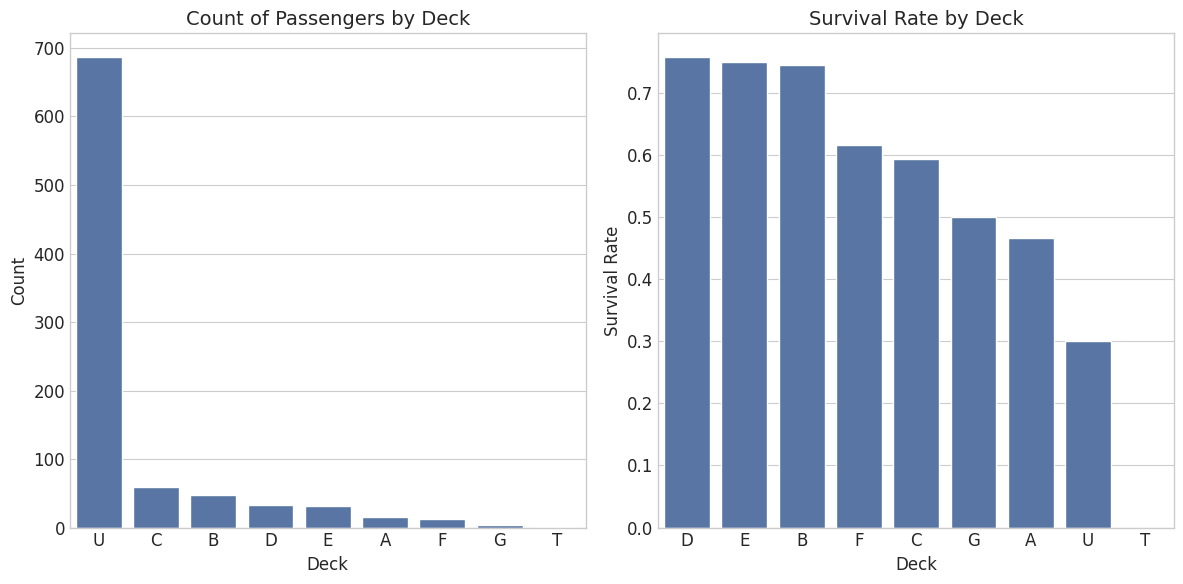

In [ ]:
# 7. Survival Rate by Deck
plt.figure(figsize=(12, 6))

# Count plot of Deck
plt.subplot(1, 2, 1)
deck_counts = df_processed['Deck'].value_counts()
sns.barplot(x=deck_counts.index, y=deck_counts.values)
plt.title('Count of Passengers by Deck', fontsize=14)
plt.xlabel('Deck', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Survival rate by Deck
plt.subplot(1, 2, 2)
survival_rate = df_processed.groupby('Deck')['Survived'].mean().sort_values(ascending=False)
sns.barplot(x=survival_rate.index, y=survival_rate.values)
plt.title('Survival Rate by Deck', fontsize=14)
plt.xlabel('Deck', fontsize=12)
plt.ylabel('Survival Rate', fontsize=12)

plt.tight_layout()
plt.show()

# **6.3 Multivariate Analysis with New Features**

<Figure size 1200x600 with 0 Axes>

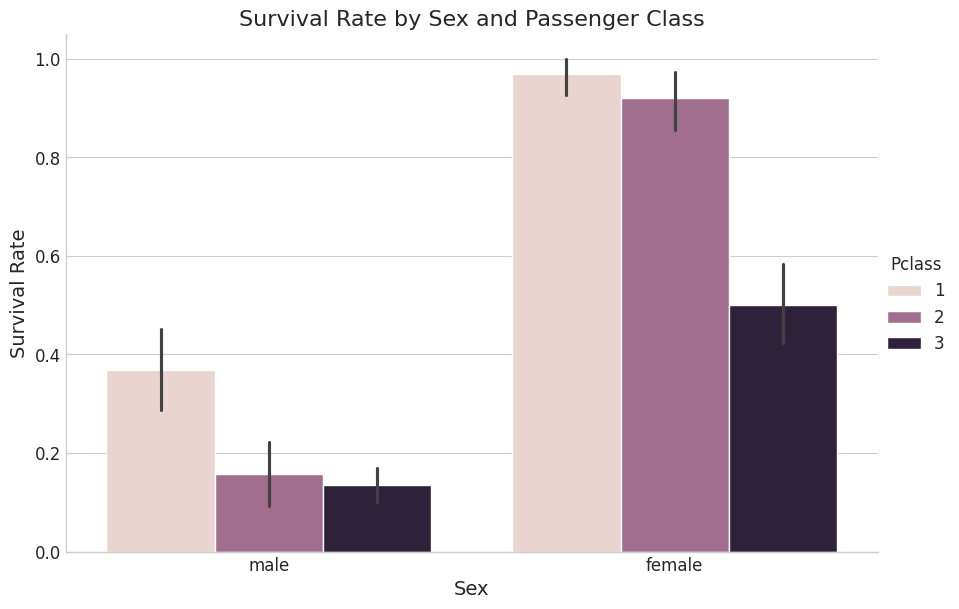

In [ ]:
# 1. Survival Rate by Sex and Pclass
plt.figure(figsize=(12, 6))
sns.catplot(x='Sex', y='Survived', hue='Pclass', kind='bar', data=df_processed, height=6, aspect=1.5)
plt.title('Survival Rate by Sex and Passenger Class', fontsize=16)
plt.xlabel('Sex', fontsize=14)
plt.ylabel('Survival Rate', fontsize=14)
plt.show()

<Figure size 1200x600 with 0 Axes>

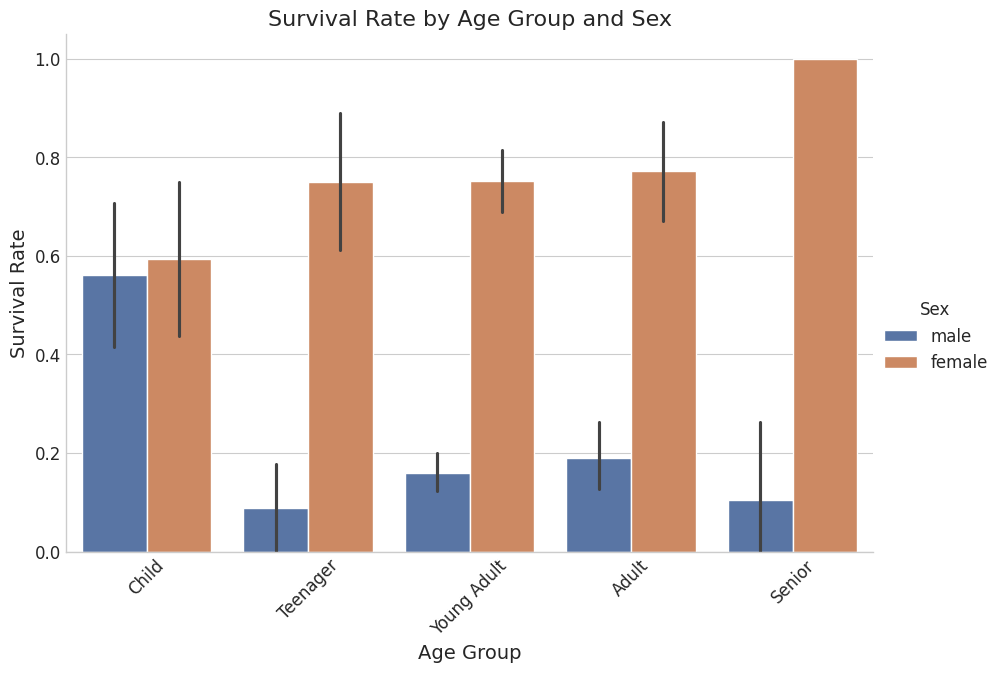

In [ ]:
# 2. Survival Rate by AgeGroup and Sex
plt.figure(figsize=(12, 6))
sns.catplot(x='AgeGroup', y='Survived', hue='Sex', kind='bar', data=df_processed,
            order=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior'], height=6, aspect=1.5)
plt.title('Survival Rate by Age Group and Sex', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Survival Rate', fontsize=14)
plt.xticks(rotation=45)
plt.show()